# Demanda de aluguel de bicicletas (Bike Sharing Demand)

- Competição do Kaggle.

Objetivo
Prever a demanda de aluguel de bicicletas por hora da cidade de Washington D.C a partir de dados meteorológicos históricos. O dataset de treino e teste são referentes aos anos de 2011 e 2012, respectivamente.

Base de dados
Colunas:
season: estação do ano

1 = primavera
2 = verão
3 = outono
4 = inverno
month: mês [1->12]

hour: hora [0->23]

holiday: se o dia é considerado feriado

weekday: dia da semana [0->6]

workingday: se é um dia útil

weather: tempo

1 = Céu limpo, poucas nuvens
2 = Névoa + Nublado
3 = chuva fraca + trovoada
4 = Chuva forte
temp: temperatura em Celsius

feel_temp: sensação térmica em Celcius

humidity: umidade relativa

windspeed: velocidade do vento

count: número total de aluguéis

In [140]:
import seaborn as sns
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.compose import TransformedTargetRegressor

In [141]:
df_train = pd.read_csv('C:/Users/ewert/Desktop/Demanda-de-bikes-compartilhadas/data/train.csv')
df_test = pd.read_csv('C:/Users/ewert/Desktop/Demanda-de-bikes-compartilhadas/data/test.csv')

In [142]:
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [143]:
df_train.shape

(10886, 12)

In [144]:
df_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [145]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [146]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [147]:
df_train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [148]:
total_na = df_train.isnull().sum()
print(total_na)

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


In [149]:
df_train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [150]:
cols = ['datetime', 'season', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']

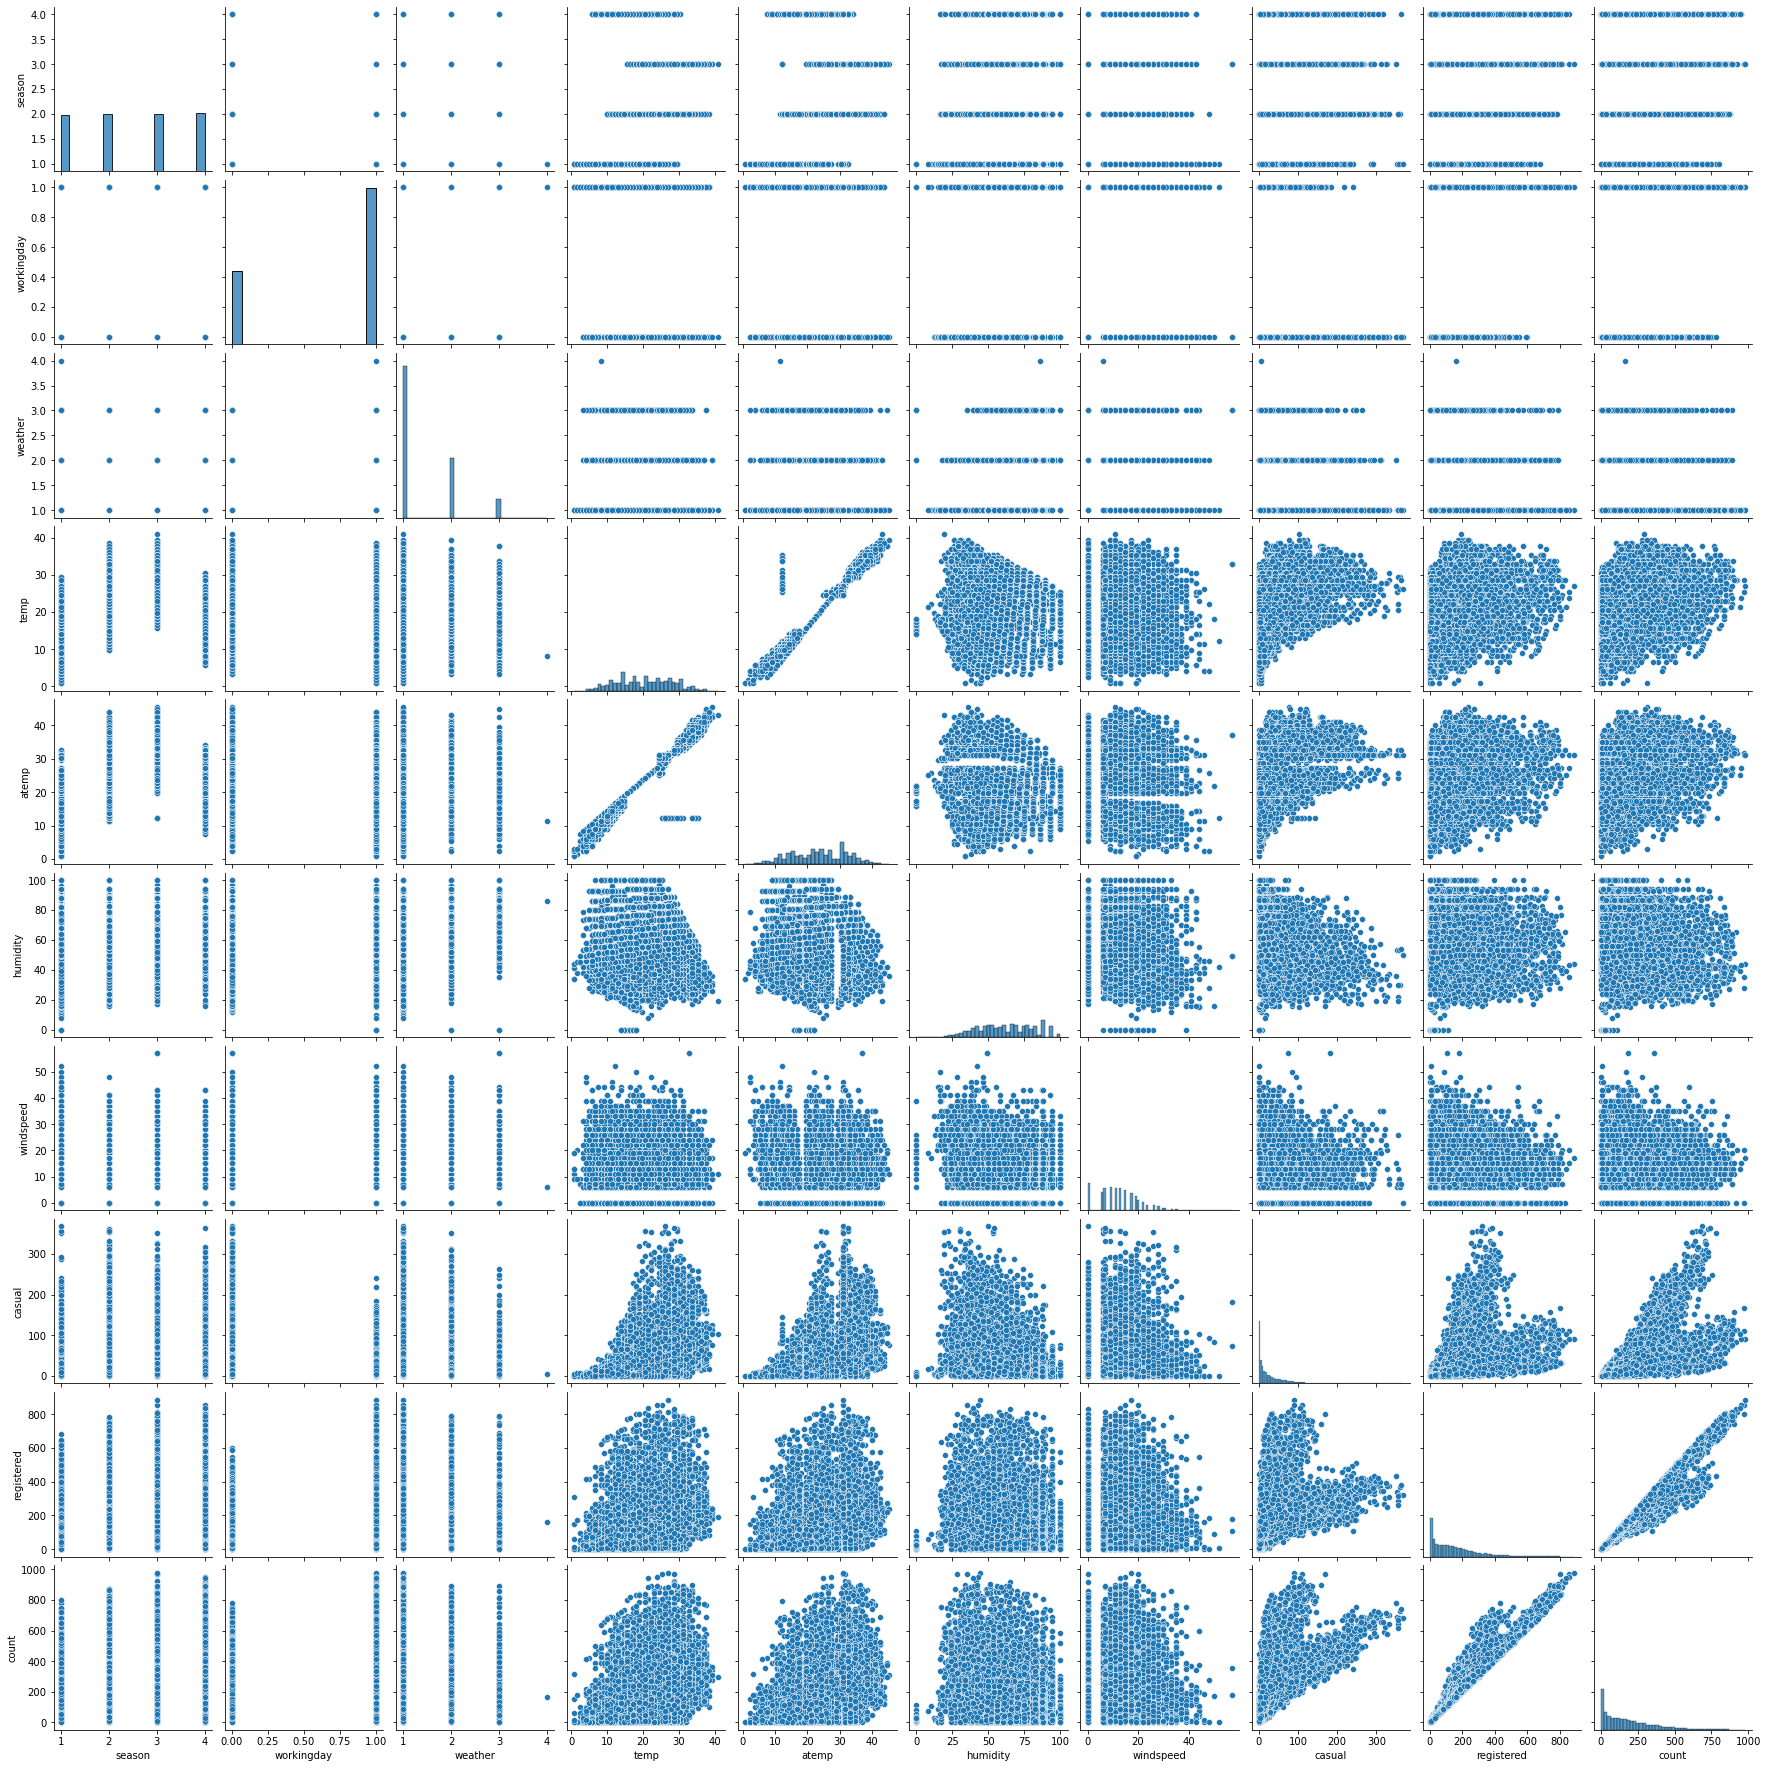

In [151]:
sns.pairplot(df_train[cols], diag_kind='hist')

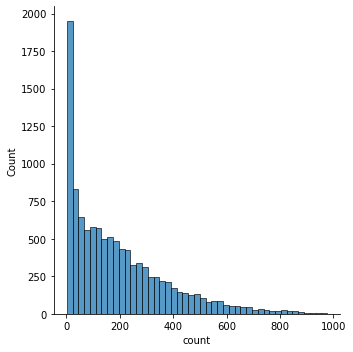

In [152]:
sns.displot(df_train['count'])

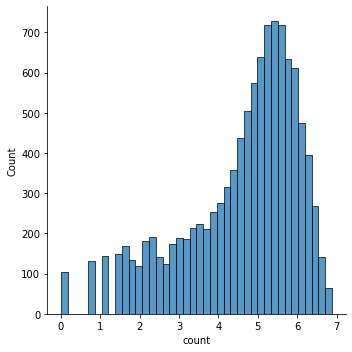

In [153]:
sns.displot(np.log(df_train['count']))

In [154]:
mean_datetime = df_train.groupby(['datetime', 'workingday'])['count'].mean().reset_index()
mean_datetime

,datetime,workingday,count
0,2011-01-01 00:00:00,0,16
1,2011-01-01 01:00:00,0,40
2,2011-01-01 02:00:00,0,32
3,2011-01-01 03:00:00,0,13
4,2011-01-01 04:00:00,0,1
...,...,...,...
10881,2012-12-19 19:00:00,1,336
10882,2012-12-19 20:00:00,1,241
10883,2012-12-19 21:00:00,1,168
10884,2012-12-19 22:00:00,1,129


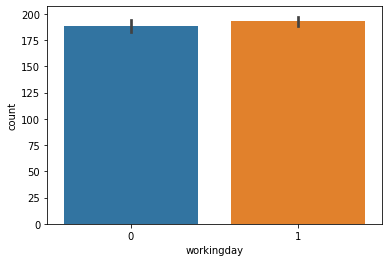

In [155]:
sns.barplot(x=df_train['workingday'], y=df_train['count'])

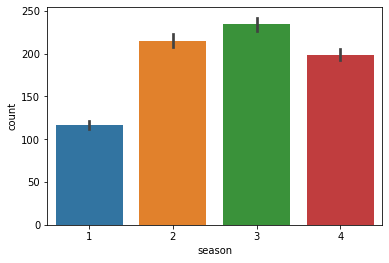

In [156]:
sns.barplot(x=df_train['season'], y= df_train['count'])

- 1 Primavera
- 2 Verão
- 3 Outono
- 4 Inverno

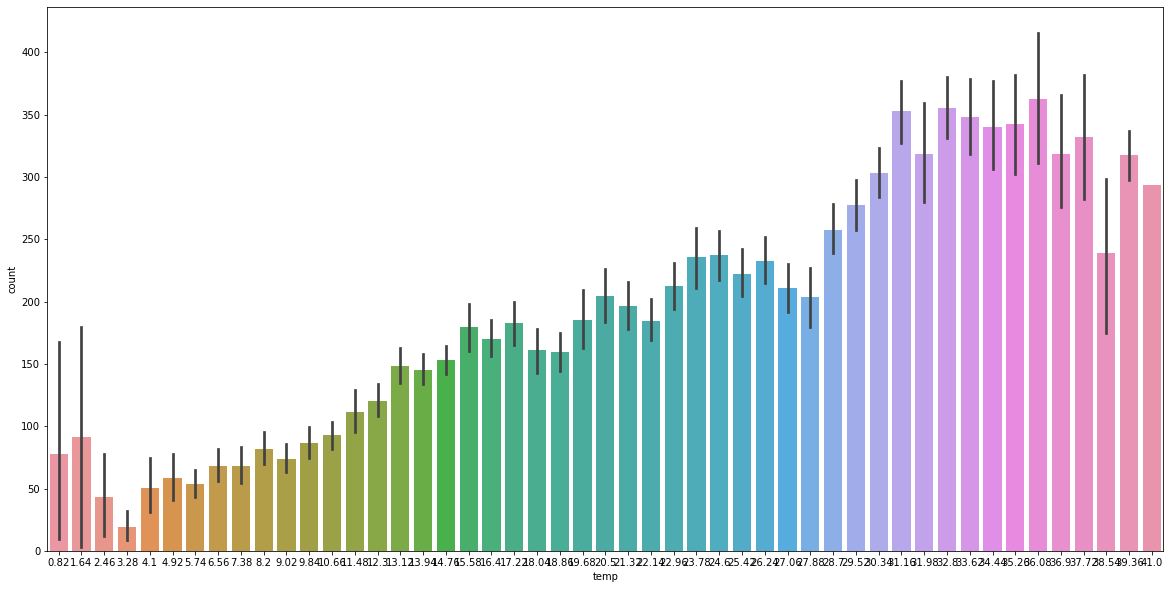

In [157]:
plt.figure(figsize=[20,10])
sns.barplot(x=df_train['temp'], y=df_train['count'])

- Quanto maior a temperatura, mais bikes são usadas. No verão as pessoas estão mais propensas a alugar uma bike.

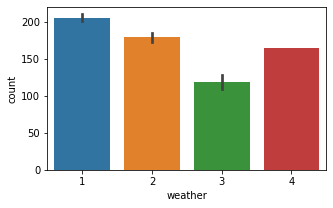

In [158]:
plt.figure(figsize=[5,3])
sns.barplot(x=df_train['weather'], y=df_train['count'])

- 1 = Céu limpo, poucas nuvens
- 2 = Névoa + Nublado
- 3 = chuva fraca + trovoada
- 4 = Chuva forte

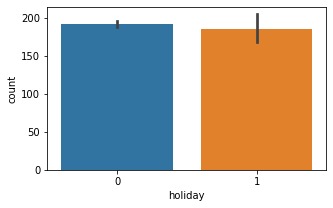

In [159]:
plt.figure(figsize=[5,3])
sns.barplot(x=df_train['holiday'], y=df_train['count'])

- 1 = Feriado
- 0 = Dia útil

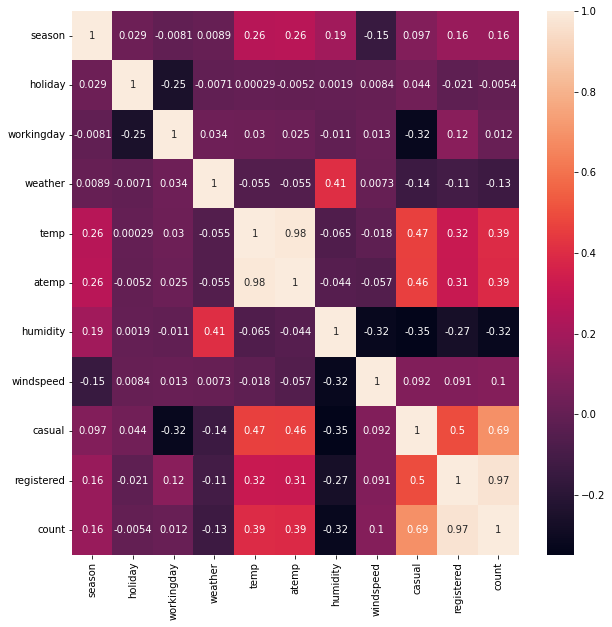

In [160]:
plt.figure(figsize=[10,10])
sns.heatmap(df_train.corr(), annot=True )

In [161]:
X = df_train.drop(columns=['count','datetime'], axis=1)
y = df_train['count']

X = X.dropna()
df_test = df_test.drop(columns=['datetime'])

In [162]:
X_train, y_train, X_test, y_test = train_test_split(X,y, test_size=0.2, random_state=42, )

In [163]:
def log_target(target):
    return np.log(target)

def exp_log_target(target):
    return np.exp(target)

In [164]:
pipeline = Pipeline([
        ('target_traform_regressor', TransformedTargetRegressor(regressor=RandomForestRegressor(), func= log_target, inverse_func=exp_log_target)),
])

In [165]:
pipeline.fit(X_train, y_train)

C:\Users\ewert\AppData\Local\Temp/ipykernel_11644/2501785045.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(target)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
y_pred_test = pipeline.predict(X_test)